In [30]:
import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
BASE = '../datasets/godaddy-microbusiness-density-forecasting/'
import mlflow

In [44]:
mlflow.xgboost.autolog()

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("gibaexp")


2023/01/01 22:01:53 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/01/01 22:01:53 INFO mlflow.tracking.fluent: Experiment with name 'gibaexp' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/2', creation_time=1672606913092, experiment_id='2', last_update_time=1672606913092, lifecycle_stage='active', name='gibaexp', tags={}>

In [3]:
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
train.shape, test.shape, sub.shape

((122265, 7), (25080, 3), (25080, 2))

In [6]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [5]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [7]:
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values('row_id').reset_index(drop=True)
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
147335,9015_2022-09-01,9015,Windham County,Connecticut,2022-09-01,3.567954,3337.0,0
147336,9015_2022-10-01,9015,Windham County,Connecticut,2022-10-01,3.566885,3336.0,0
147337,9015_2022-11-01,9015,NaN,NaN,2022-11-01,NaN,NaN,1
147338,9015_2022-12-01,9015,NaN,NaN,2022-12-01,NaN,NaN,1
147339,9015_2023-01-01,9015,NaN,NaN,2023-01-01,NaN,NaN,1
147340,9015_2023-02-01,9015,NaN,NaN,2023-02-01,NaN,NaN,1
147341,9015_2023-03-01,9015,NaN,NaN,2023-03-01,NaN,NaN,1
147342,9015_2023-04-01,9015,NaN,NaN,2023-04-01,NaN,NaN,1
147343,9015_2023-05-01,9015,NaN,NaN,2023-05-01,NaN,NaN,1
147344,9015_2023-06-01,9015,NaN,NaN,2023-06-01,NaN,NaN,1


In [8]:
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips', 'istest'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(10)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147335,9015_2022-09-01,9015,Windham County,Connecticut,2022-09-01,3.567954,3337.0,0,2022,9,37,3134,50
147336,9015_2022-10-01,9015,Windham County,Connecticut,2022-10-01,3.566885,3336.0,0,2022,10,38,3134,50
147337,9015_2022-11-01,9015,Windham County,Connecticut,2022-11-01,NaN,NaN,1,2022,11,0,3134,50
147338,9015_2022-12-01,9015,Windham County,Connecticut,2022-12-01,NaN,NaN,1,2022,12,1,3134,50
147339,9015_2023-01-01,9015,Windham County,Connecticut,2023-01-01,NaN,NaN,1,2023,1,2,3134,50
147340,9015_2023-02-01,9015,Windham County,Connecticut,2023-02-01,NaN,NaN,1,2023,2,3,3134,50
147341,9015_2023-03-01,9015,Windham County,Connecticut,2023-03-01,NaN,NaN,1,2023,3,4,3134,50
147342,9015_2023-04-01,9015,Windham County,Connecticut,2023-04-01,NaN,NaN,1,2023,4,5,3134,50
147343,9015_2023-05-01,9015,Windham County,Connecticut,2023-05-01,NaN,NaN,1,2023,5,6,3134,50
147344,9015_2023-06-01,9015,Windham County,Connecticut,2023-06-01,NaN,NaN,1,2023,6,7,3134,50


In [9]:
def build_features(raw):

    for lag in range(1, 36):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')['active'].shift(lag)
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].bfill()
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[f'act_lag_{lag}'].bfill()
        
    return raw
    
raw = build_features(raw)
gc.collect()
raw.tail(20)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,mbd_lag_31,act_lag_31,mbd_lag_32,act_lag_32,mbd_lag_33,act_lag_33,mbd_lag_34,act_lag_34,mbd_lag_35,act_lag_35
147325,9015_2021-11-01,9015,Windham County,Connecticut,2021-11-01,3.560204,3319.0,0,2021,11,...,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147326,9015_2021-12-01,9015,Windham County,Connecticut,2021-12-01,3.530169,3291.0,0,2021,12,...,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147327,9015_2022-01-01,9015,Windham County,Connecticut,2022-01-01,3.524116,3296.0,0,2022,1,...,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147328,9015_2022-02-01,9015,Windham County,Connecticut,2022-02-01,3.492040,3266.0,0,2022,2,...,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147329,9015_2022-03-01,9015,Windham County,Connecticut,2022-03-01,3.519839,3292.0,0,2022,3,...,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147330,9015_2022-04-01,9015,Windham County,Connecticut,2022-04-01,3.538016,3309.0,0,2022,4,...,3.754211,3488.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147331,9015_2022-05-01,9015,Windham County,Connecticut,2022-05-01,3.524116,3296.0,0,2022,5,...,3.748830,3483.0,3.754211,3488.0,3.702548,3440.0,3.702548,3440.0,3.702548,3440.0
147332,9015_2022-06-01,9015,Windham County,Connecticut,2022-06-01,3.521978,3294.0,0,2022,6,...,3.796188,3527.0,3.748830,3483.0,3.754211,3488.0,3.702548,3440.0,3.702548,3440.0
147333,9015_2022-07-01,9015,Windham County,Connecticut,2022-07-01,3.574369,3343.0,0,2022,7,...,3.887675,3612.0,3.796188,3527.0,3.748830,3483.0,3.754211,3488.0,3.702548,3440.0
147334,9015_2022-08-01,9015,Windham County,Connecticut,2022-08-01,3.552985,3323.0,0,2022,8,...,3.932530,3658.0,3.887675,3612.0,3.796188,3527.0,3.748830,3483.0,3.754211,3488.0


In [10]:
raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_lag_4
147325,9015_2021-11-01,9015,Windham County,Connecticut,2021-11-01,3.560204,3319.0,0,2021,11,27,3134,50,3.538750,3299.0,3.541968,3302.0,3.555913,3315.0,3.536605
147326,9015_2021-12-01,9015,Windham County,Connecticut,2021-12-01,3.530169,3291.0,0,2021,12,28,3134,50,3.560204,3319.0,3.538750,3299.0,3.541968,3302.0,3.555913
147327,9015_2022-01-01,9015,Windham County,Connecticut,2022-01-01,3.524116,3296.0,0,2022,1,29,3134,50,3.530169,3291.0,3.560204,3319.0,3.538750,3299.0,3.541968
147328,9015_2022-02-01,9015,Windham County,Connecticut,2022-02-01,3.492040,3266.0,0,2022,2,30,3134,50,3.524116,3296.0,3.530169,3291.0,3.560204,3319.0,3.538750
147329,9015_2022-03-01,9015,Windham County,Connecticut,2022-03-01,3.519839,3292.0,0,2022,3,31,3134,50,3.492040,3266.0,3.524116,3296.0,3.530169,3291.0,3.560204
147330,9015_2022-04-01,9015,Windham County,Connecticut,2022-04-01,3.538016,3309.0,0,2022,4,32,3134,50,3.519839,3292.0,3.492040,3266.0,3.524116,3296.0,3.530169
147331,9015_2022-05-01,9015,Windham County,Connecticut,2022-05-01,3.524116,3296.0,0,2022,5,33,3134,50,3.538016,3309.0,3.519839,3292.0,3.492040,3266.0,3.524116
147332,9015_2022-06-01,9015,Windham County,Connecticut,2022-06-01,3.521978,3294.0,0,2022,6,34,3134,50,3.524116,3296.0,3.538016,3309.0,3.519839,3292.0,3.492040
147333,9015_2022-07-01,9015,Windham County,Connecticut,2022-07-01,3.574369,3343.0,0,2022,7,35,3134,50,3.521978,3294.0,3.524116,3296.0,3.538016,3309.0,3.519839
147334,9015_2022-08-01,9015,Windham County,Connecticut,2022-08-01,3.552985,3323.0,0,2022,8,36,3134,50,3.574369,3343.0,3.521978,3294.0,3.524116,3296.0,3.538016


In [11]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

print( smape( np.array([0, 0]),  np.array([0, 0]) ) )
print( smape( np.array([0, 0]),  np.array([0, 1]) ) )
print( smape( np.array([0, 0]),  np.array([1, 0]) ) )
print( smape( np.array([0, 0]),  np.array([1, 1]) ) )


0.0
100.0
100.0
200.0


In [12]:
for i in range(1, 36):
    print(f'smape lag{i}:', smape(raw.loc[raw.istest==0, 'microbusiness_density'], raw.loc[raw.istest==0, f'mbd_lag_{i}']))

smape lag1: 1.7734758535302604
smape lag2: 2.7259900745367
smape lag3: 3.503406134878052
smape lag4: 4.1912691031730365
smape lag5: 4.809293512213896
smape lag6: 5.348228883210647
smape lag7: 5.839025459304811
smape lag8: 6.29824227609533
smape lag9: 6.722542484734956
smape lag10: 7.098032215458787
smape lag11: 7.435749149763511
smape lag12: 7.76120120487487
smape lag13: 8.064646357289854
smape lag14: 8.32936133563068
smape lag15: 8.577042891466128
smape lag16: 8.807212609271446
smape lag17: 9.02661927618708
smape lag18: 9.215772673386292
smape lag19: 9.404178773177838
smape lag20: 9.578692029907266
smape lag21: 9.732264380726814
smape lag22: 9.817313317058158
smape lag23: 9.901148616306681
smape lag24: 9.986461317196287
smape lag25: 10.071639912560638
smape lag26: 10.149463774023006
smape lag27: 10.217080317646046
smape lag28: 10.279527246033132
smape lag29: 10.32748561740011
smape lag30: 10.365274724750714
smape lag31: 10.393769520654855
smape lag32: 10.409652261604819
smape lag33: 1

In [13]:
LAG_FEATURES = list(raw.columns[13:]) 
print(LAG_FEATURES)

['mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_lag_4', 'act_lag_4', 'mbd_lag_5', 'act_lag_5', 'mbd_lag_6', 'act_lag_6', 'mbd_lag_7', 'act_lag_7', 'mbd_lag_8', 'act_lag_8', 'mbd_lag_9', 'act_lag_9', 'mbd_lag_10', 'act_lag_10', 'mbd_lag_11', 'act_lag_11', 'mbd_lag_12', 'act_lag_12', 'mbd_lag_13', 'act_lag_13', 'mbd_lag_14', 'act_lag_14', 'mbd_lag_15', 'act_lag_15', 'mbd_lag_16', 'act_lag_16', 'mbd_lag_17', 'act_lag_17', 'mbd_lag_18', 'act_lag_18', 'mbd_lag_19', 'act_lag_19', 'mbd_lag_20', 'act_lag_20', 'mbd_lag_21', 'act_lag_21', 'mbd_lag_22', 'act_lag_22', 'mbd_lag_23', 'act_lag_23', 'mbd_lag_24', 'act_lag_24', 'mbd_lag_25', 'act_lag_25', 'mbd_lag_26', 'act_lag_26', 'mbd_lag_27', 'act_lag_27', 'mbd_lag_28', 'act_lag_28', 'mbd_lag_29', 'act_lag_29', 'mbd_lag_30', 'act_lag_30', 'mbd_lag_31', 'act_lag_31', 'mbd_lag_32', 'act_lag_32', 'mbd_lag_33', 'act_lag_33', 'mbd_lag_34', 'act_lag_34', 'mbd_lag_35', 'act_lag_35']


In [46]:
for lead in range(8):

    with mlflow.start_run(run_name=f"Runconfig{lead}"):

        mlflow.set_tag("model", "xgboost")

        mlflow.log_params({f"lead": lead})


        print(lead)
        
        model = xgb.XGBRegressor(
            tree_method="hist",
            n_estimators=2000,
            learning_rate=0.025,
            #max_depth=8,
            max_leaves = 255,
            subsample=0.60,
            colsample_bytree=0.90,
            max_bin=256,
            n_jobs=2,
            eval_metric=smape, 
            disable_default_eval_metric=True,
            early_stopping_rounds=50,
        )

        features = []
        for f in LAG_FEATURES:
            if (int(f.split('_')[-1]) >= (lead+1)) and (int(f.split('_')[-1]) <= (lead+32)):
                features.append(f)
        fw = np.ones(len(features))
        fw[0] = len(fw)
        fw /= np.sum(fw)
                
        train_indices = (raw.istest==0) & (raw.dcount != 38)
        valid_indices = (raw.istest==0) & (raw.dcount == 38)
        model.fit(
            raw.loc[train_indices, features],
            raw.loc[train_indices, 'microbusiness_density'],
            eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'microbusiness_density'])],
            verbose=50,
            feature_weights=fw,
        )
        
        '''model = xgb.XGBRegressor(
            tree_method="hist",
            n_estimators=model.best_iteration+1,
            learning_rate=0.025,
            #max_depth=8,
            max_leaves = 255,
            subsample=0.60,
            colsample_bytree=0.90,
            max_bin=256,
            n_jobs=2,
            #eval_metric=smape, 
            #disable_default_eval_metric=True,
            #early_stopping_rounds=50,
        )    
        train_indices = (raw.istest==0)
        model.fit(
            raw.loc[train_indices, features],
            raw.loc[train_indices, 'microbusiness_density'],
            feature_weights=fw,
        )'''    

        mlflow.log_metric("rmse", model.evals_result()["validation_0"]["smape"][-1])
        mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path="xgboost-model",
        registered_model_name="xgboost-model"
        )


        test_indices = (raw.istest==1) & (raw.dcount == lead)
        raw.loc[test_indices, 'microbusiness_density'] = model.predict(raw.loc[test_indices, features])
        print()

0
[0]	validation_0-smape:125.77574
[50]	validation_0-smape:24.30199
[100]	validation_0-smape:6.67263
[150]	validation_0-smape:2.52805
[200]	validation_0-smape:1.75555
[250]	validation_0-smape:1.67265
[300]	validation_0-smape:1.66684
[350]	validation_0-smape:1.65925
[400]	validation_0-smape:1.65338
[450]	validation_0-smape:1.64543
[500]	validation_0-smape:1.63952
[550]	validation_0-smape:1.63561
[600]	validation_0-smape:1.63111
[650]	validation_0-smape:1.63059
[664]	validation_0-smape:1.63033


2023/01/01 22:04:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Successfully registered model 'xgboost-model'.
2023/01/01 22:04:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 1
Created version '1' of model 'xgboost-model'.



1
[0]	validation_0-smape:125.77916
[50]	validation_0-smape:24.36518
[100]	validation_0-smape:6.87424
[150]	validation_0-smape:3.09922
[200]	validation_0-smape:2.48716
[250]	validation_0-smape:2.41967
[300]	validation_0-smape:2.41326
[350]	validation_0-smape:2.40198
[400]	validation_0-smape:2.39222
[450]	validation_0-smape:2.38728
[491]	validation_0-smape:2.39787


2023/01/01 22:04:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:04:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 2
Created version '2' of model 'xgboost-model'.



2
[0]	validation_0-smape:125.72836
[50]	validation_0-smape:23.77664
[100]	validation_0-smape:6.66501
[150]	validation_0-smape:3.40971
[200]	validation_0-smape:3.09912
[243]	validation_0-smape:3.13141


2023/01/01 22:04:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:04:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 3
Created version '3' of model 'xgboost-model'.



3
[0]	validation_0-smape:125.82818
[50]	validation_0-smape:25.12763
[100]	validation_0-smape:8.10958
[150]	validation_0-smape:4.62321
[200]	validation_0-smape:3.99007
[250]	validation_0-smape:3.87492
[300]	validation_0-smape:3.85045
[350]	validation_0-smape:3.82943
[400]	validation_0-smape:3.82120
[447]	validation_0-smape:3.82245


2023/01/01 22:05:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:05:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 4
Created version '4' of model 'xgboost-model'.



4
[0]	validation_0-smape:125.83306
[50]	validation_0-smape:25.53512
[100]	validation_0-smape:8.77820
[150]	validation_0-smape:5.42421
[200]	validation_0-smape:4.81580
[250]	validation_0-smape:4.68897
[300]	validation_0-smape:4.66380
[350]	validation_0-smape:4.64807
[400]	validation_0-smape:4.64046
[450]	validation_0-smape:4.63395
[500]	validation_0-smape:4.62837
[550]	validation_0-smape:4.63783
[552]	validation_0-smape:4.63683


2023/01/01 22:05:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:05:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 5
Created version '5' of model 'xgboost-model'.



5
[0]	validation_0-smape:125.79968
[50]	validation_0-smape:25.04679
[100]	validation_0-smape:8.54452
[150]	validation_0-smape:5.36880
[200]	validation_0-smape:4.87472
[250]	validation_0-smape:4.78769
[300]	validation_0-smape:4.76978
[350]	validation_0-smape:4.76192
[400]	validation_0-smape:4.74948
[450]	validation_0-smape:4.75462
[459]	validation_0-smape:4.75391


2023/01/01 22:06:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:06:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 6
Created version '6' of model 'xgboost-model'.



6
[0]	validation_0-smape:125.80930
[50]	validation_0-smape:25.21436
[100]	validation_0-smape:8.94405
[150]	validation_0-smape:5.94355
[200]	validation_0-smape:5.48829
[250]	validation_0-smape:5.40828
[300]	validation_0-smape:5.36700
[350]	validation_0-smape:5.35755
[400]	validation_0-smape:5.34676
[450]	validation_0-smape:5.34079
[500]	validation_0-smape:5.33631
[550]	validation_0-smape:5.32649
[599]	validation_0-smape:5.33282


2023/01/01 22:06:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:06:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 7
Created version '7' of model 'xgboost-model'.



7
[0]	validation_0-smape:125.85548
[50]	validation_0-smape:25.83334
[100]	validation_0-smape:9.60843
[150]	validation_0-smape:6.57903
[200]	validation_0-smape:6.05192
[250]	validation_0-smape:5.95985
[300]	validation_0-smape:5.91944
[350]	validation_0-smape:5.91081
[400]	validation_0-smape:5.88809
[448]	validation_0-smape:5.89638


2023/01/01 22:06:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codeastra/anaconda3/envs/mlops/lib/python3.10/site-packages/xgboost/sklearn.py:787: UserWarning: eval_metric is not saved in Scikit-Learn meta."
Registered model 'xgboost-model' already exists. Creating a new version of this model...
2023/01/01 22:06:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost-model, version 8


Created version '8' of model 'xgboost-model'.


In [28]:
model.evals_result()["validation_0"]["smape"][-1]

5.896377

<AxesSubplot:xlabel='first_day_of_month'>

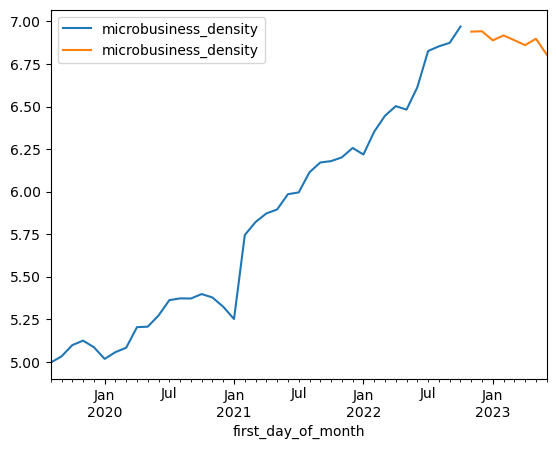

In [37]:
ax = raw.loc[(raw.cfips==10001)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==10001)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

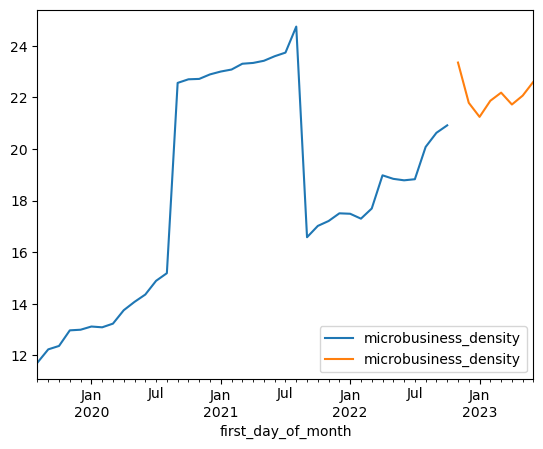

In [38]:
ax = raw.loc[(raw.cfips==10003)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==10003)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

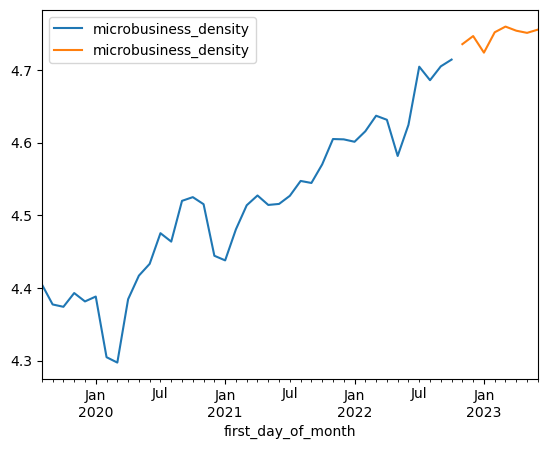

In [39]:
ax = raw.loc[(raw.cfips==9011)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9011)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

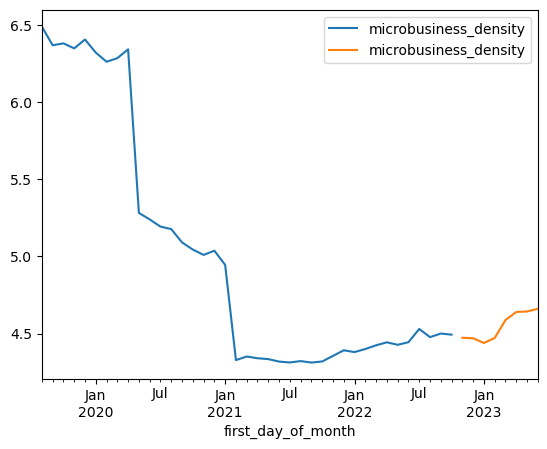

In [40]:
ax = raw.loc[(raw.cfips==9013)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9013)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

<AxesSubplot:xlabel='first_day_of_month'>

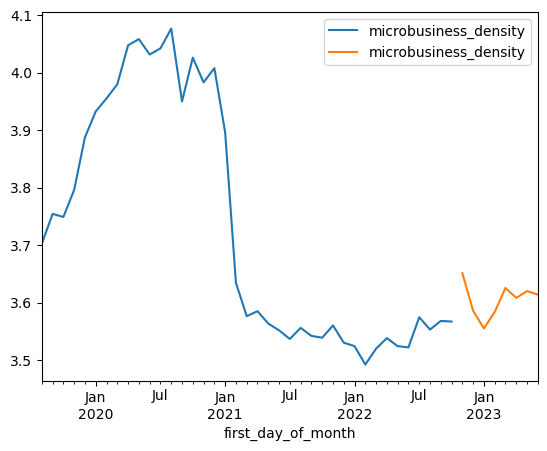

In [41]:
ax = raw.loc[(raw.cfips==9015)&(raw.istest==0)].plot(x='first_day_of_month', y='microbusiness_density')
raw.loc[(raw.cfips==9015)&(raw.istest==1)].plot(ax=ax, x='first_day_of_month', y='microbusiness_density')

In [42]:
test = raw.loc[raw.istest==1, ['row_id', 'microbusiness_density']].copy()
test.to_csv('submission.csv', index=False)
test.head(40)

,row_id,microbusiness_density
39,10001_2022-11-01,6.940016
40,10001_2022-12-01,6.941969
41,10001_2023-01-01,6.888827
42,10001_2023-02-01,6.917625
43,10001_2023-03-01,6.889400
44,10001_2023-04-01,6.860573
45,10001_2023-05-01,6.898122
46,10001_2023-06-01,6.804854
86,10003_2022-11-01,23.351017
87,10003_2022-12-01,21.790327
